In [1]:
import os
import glob
import rosbag
import rosbag_pandas
import numpy as np
import pandas as pd
import timeit
import cv2
import time 

from os import path
import matplotlib.pyplot as plt
from cv_bridge import CvBridge, CvBridgeError
from pypeln import thread as th

In [2]:
BAG_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/'

In [3]:
files = glob.glob(BAG_FOLDER + '/*/**.bag')
files

['/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444482.8294413.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444486.0404367.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444506.1394608.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444518.9448862.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444539.2530274.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444559.8300471.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444580.3780055.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444600.9569342.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444621.4346867.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bars1/1542444641.97341.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bumps1/1542445123.896269.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bumps1/1542445144.416422.bag',
 '/home/francesco/Desktop/carino/vaevictis/data/bumps1

In [4]:
def filename2map(filename):
    dirs, _ = path.split(filename)
    map_name = path.basename(dirs)
    
    return map_name

In [5]:
def bag2df(file_name):
    df = None
    try:
        df = rosbag_pandas.bag_to_dataframe(file_name) 
    except TypeError:
        print(file_name)
    map_name = filename2map(file_name)
    return (map_name, df )

In [6]:
stage = th.map(bag2df, files, workers = 16)

data = list(stage)

In [7]:
len(data)

150

In [8]:
df = pd.concat([df for (m, df) in data])

In [9]:
# bag = rosbag.Bag(files[2])
# bridge = CvBridge()

# for topic, msg, t in bag.read_messages(topics=['frontal_camera']):
#     img = bridge.imgmsg_to_cv2(msg, "bgr8")
#     cv2.imshow('img', img)
#     print(img.shape)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
# bag.close()

In [33]:
def create_trace_world(df, res=0.1):
    x = df.pose__pose_position_x
    y = df.pose__pose_position_y

    X = np.arange(-5, 5,res)
    Y = np.arange(-5, 5, res)
    world = np.zeros((X.shape[0], Y.shape[0]))
   
    for x_, y_ in zip(x,y):
        xi = np.digitize(x_, X) - 1
        yi = np.digitize(y_, Y) - 1
        world[xi, yi] += 1    

    world /= len(x)
    world = world.T
    
    return world, X, Y

In [34]:
def create2dtrace(df):
    import ipympl
    import matplotlib.pyplot as plt
    from mpl_toolkits import mplot3d
    
    fig = plt.figure()

    plt.rcParams['figure.figsize'] = [8, 5]
    plt.imshow(world * 255)
    plt.show()

In [63]:
def create3dtrace(world,X, Y,map_name):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.colors as mcolors
    import matplotlib
    
    
    Xm, Ym = np.meshgrid(X, Y)
    Z = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}.png'.format(map_name))
    Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
    Z = Z / 255
    Z = cv2.resize(Z, Xm.shape, cv2.INTER_CUBIC) 
    
    # fourth dimention - colormap
    # create colormap according to x-value (can use any 50x50 array)
    color_dimension = world # change to desired fourth dimension
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = matplotlib.colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm)
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(Xm, Ym, Z,  facecolors=fcolors, linewidth=0.1)
    plt.show()

In [64]:
Z = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}.png'.format(data[0][0]))

plt.imshow(Z)
plt.show()

In [65]:
%matplotlib notebook

In [66]:
run = data[1]

In [67]:
len(run[1])


4642

<IPython.core.display.Javascript object>


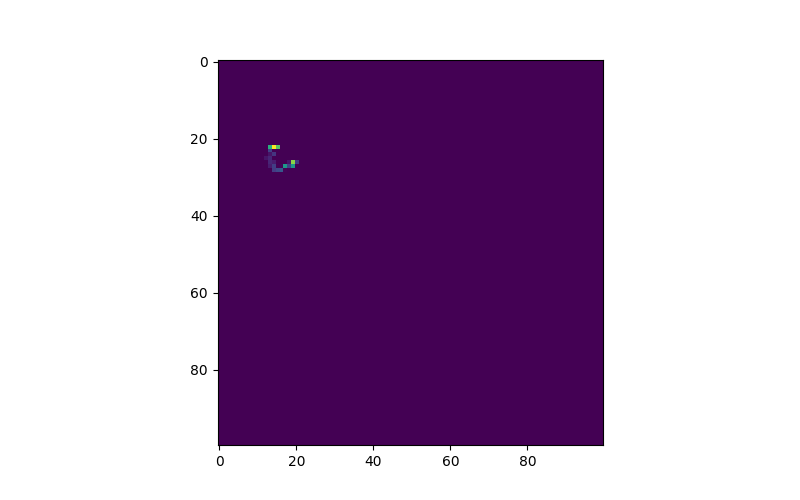

In [68]:
world, X, Y = create_trace_world(run[1])
create2dtrace(world)

<IPython.core.display.Javascript object>


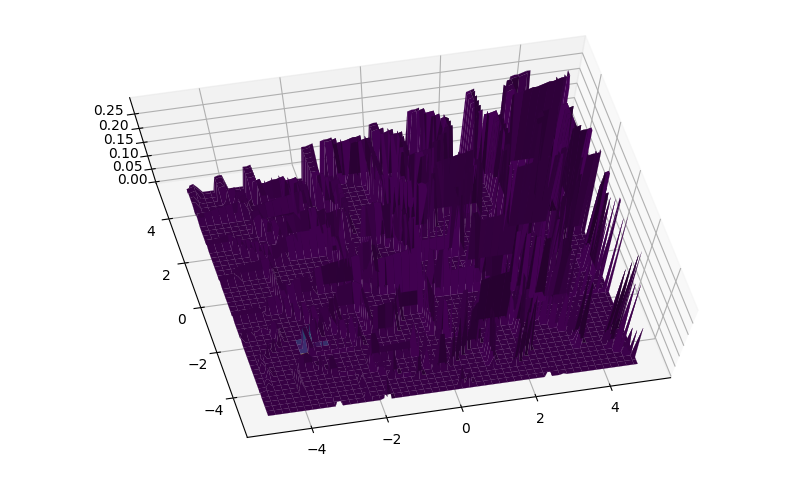

In [69]:
create3dtrace(world, X, Y, run[0])